# CIFAR 10 Example
Since my experience until now has been mostly with Tensorflow/Keras, this notebook is intended to play around with PyTorch and run through their tutorial for training on the CIFAR10 dataset. In addition - it will be all done on the gpu.

### What is CIFAR 10?
Taken straight from the [website](https://www.cs.toronto.edu/~kriz/cifar.html):
"The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class."

### What is the goal?
As an introduction to PyTorch - use the tutorial, get its results and improve them.

### Project Structure:

1. Loading the data & Loading the libraries.
2. Showing a sample of images.
3. Defining and training a convolutional neural network.
    * The plan here is to explore the implementation of different architectures.
4. Evaluating the results.
5. Improving the results.
    * Different optimizers.
    * Transfer Learning.

...

### References
* [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky
* [Training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html), PyTorch

## 1. Loading the data & Loading the libraries.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [2]:
# Set the device to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

First I will try to mimic the tutorial from Torch's website then implement it my way.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./datasets', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./datasets', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 2. Showing a sample images.

 deer plane  frog  bird


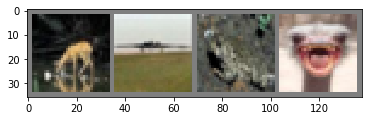

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
images[0].shape

torch.Size([3, 32, 32])

## 3. Defining a Convolutional Neural Network

Instead of using the provided CNN architecture I will design a couple of my own architectures to get the hang of PyTorch.

In [6]:
# General Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

##### -- Simple Net
Just two convolutional layers.

In [28]:
class SimpleNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.relu2 = nn.ReLU()
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(in_features=128 * 14 * 14, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=num_classes)
    
    def forward(self, inputs):
        # 1
        output = self.conv1(inputs)
        output = self.relu1(output)
        # 2
        output = self.conv2(output)
        output = self.relu2(output)
        # 3 pool
        output = self.pool(output)
        # 4 view
        output = output.view(-1, 128 * 14 * 14)
        # 5
        output = F.relu(self.fc1(output))
        output = self.fc2(output)
        
        return output

In [29]:
simple_net = SimpleNet().to(device)
summary(simple_net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
              ReLU-2           [-1, 64, 30, 30]               0
            Conv2d-3          [-1, 128, 28, 28]          73,856
              ReLU-4          [-1, 128, 28, 28]               0
         MaxPool2d-5          [-1, 128, 14, 14]               0
            Linear-6                   [-1, 64]       1,605,696
            Linear-7                   [-1, 10]             650
Total params: 1,681,994
Trainable params: 1,681,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.60
Params size (MB): 6.42
Estimated Total Size (MB): 9.03
----------------------------------------------------------------


##### -- Deeper Net
No fancy stuff though (Dropout, BatchNorm, etc, etc), just Deeper.

In [30]:
class DeeperNet(nn.Module):
    def __init__(self, num_classes=10):
        super(DeeperNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.relu2 = nn.ReLU()
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1)
        self.relu5 = nn.ReLU()
        
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(in_features=256 * 7 * 7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=10)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, inputs):
        # 1
        output = self.conv1(inputs)
        output = self.relu1(output)
        output = self.conv2(output)
        output = self.relu2(output)
        # 2 pool
        output = self.pool1(output)
        # 3 
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.conv4(output)
        output = self.relu4(output)
        output = self.conv5(output)
        output = self.relu5(output)
        # 4 pool
        output = self.pool2(output)
        # 4 view
        output = output.view(-1, 256 * 7 * 7)
        # 5
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = F.relu(self.fc3(output))
        output = self.fc4(output)
        
        return output

In [31]:
deeper_net = DeeperNet().to(device)
summary(deeper_net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
              ReLU-2           [-1, 64, 30, 30]               0
            Conv2d-3          [-1, 128, 28, 28]          73,856
              ReLU-4          [-1, 128, 28, 28]               0
         MaxPool2d-5          [-1, 128, 14, 14]               0
            Conv2d-6           [-1, 64, 14, 14]           8,256
              ReLU-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]           8,320
              ReLU-9          [-1, 128, 14, 14]               0
           Conv2d-10          [-1, 256, 14, 14]          33,024
             ReLU-11          [-1, 256, 14, 14]               0
        MaxPool2d-12            [-1, 256, 7, 7]               0
           Linear-13                  [-1, 128]       1,605,760
           Linear-14                  [

##### -- Fancy Net
Nothing really fancy about it, but just implementing batch normalization and dropout. Also trying to experiment I will try to make the network more modular.

In [32]:
# Defining a unit of the architecture containing a single convolution, batch normalization and activator
class Unit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(Unit, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        output = self.conv(inputs)
        output = self.bn(output)
        output = self.relu(output)
        
        return output

In [33]:
class FancyNet(nn.Module):
    def __init__(self, num_classes=10):
        super(FancyNet, self).__init__()
        self.unit1 = Unit(in_channels=3, out_channels=32, kernel_size=1)
        self.unit2 = Unit(in_channels=32, out_channels=32, kernel_size=1)
        self.unit3 = Unit(in_channels=32, out_channels=32, kernel_size=1)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.unit4 = Unit(in_channels=32, out_channels=64)
        self.unit5 = Unit(in_channels=64, out_channels=64)
        self.unit6 = Unit(in_channels=64, out_channels=64)
        self.unit6 = Unit(in_channels=64, out_channels=64)
        
        
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, \
                                self.unit4, self.unit5, self.unit6, self.pool2)
        
        self.fc1 = nn.Linear(in_features=64*5*5, out_features=num_classes)
        
    def forward(self, inputs):
        output = self.net(inputs)
        output = output.view(-1, 64*5*5)
        output = self.fc1(output)
        
        return output

In [34]:
fancy_net = FancyNet().to(device)
summary(fancy_net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             128
            Conv2d-2           [-1, 32, 32, 32]             128
       BatchNorm2d-3           [-1, 32, 32, 32]              64
       BatchNorm2d-4           [-1, 32, 32, 32]              64
              ReLU-5           [-1, 32, 32, 32]               0
              ReLU-6           [-1, 32, 32, 32]               0
              Unit-7           [-1, 32, 32, 32]               0
              Unit-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           1,056
           Conv2d-10           [-1, 32, 32, 32]           1,056
      BatchNorm2d-11           [-1, 32, 32, 32]              64
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
             ReLU-14           [-1, 32,

##### --Dense Net
Implementing the [ResNet-101](http://openaccess.thecvf.com/content_cvpr_2017/html/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.html) in pytorch. Not going to lie - huge help from [Sebastian Rashka's repo](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-resnet101-cifar10.ipynb).

In [ ]:
# Model
def conv3x3()

### 3.1 Defining a Loss function and optimizer

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

def define_optimizer(optimizer, lr, momentum, network):
    return optimizer(network.parameters(), lr, momentum)

Stick with Stochastic Gradient Descent for now.

In [16]:
# simple net
sn_optimizer = define_optimizer(optim.SGD, 0.01, 0.9, simple_net)
# deeper net
dn_optimizer = define_optimizer(optim.SGD, 0.01, 0.9, deeper_net)
# fancy net
fn_optimizer = define_optimizer(optim.SGD, 0.01, 0.9, fancy_net)

### 3.2 Training the Network

In [17]:
def fit_network(network, optimizer, criterion, epochs, loader):
    for epoch in range(epochs):
        
        running_loss = 0.0
        total = 0
        correct = 0
        
        for i, data in enumerate(loader):
            # inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # clear the gradients
            optimizer.zero_grad()
            # predict the parameters
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            # propagate the loss backwards
            loss.backward()
            
            # adjust the parameters according to the gradients
            optimizer.step()
            
            # print stats
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if i == (len(loader) - 1):
                print(f'[epoch:{epoch + 1}] - loss: {running_loss / len(loader)}; accuracy - {100 * correct / total}')
                running_loss = 0.0
                
    print('Finished Training')

In [79]:
# simple net fit
fit_network(simple_net, sn_optimizer, criterion, epochs=10, loader=trainloader)

[epoch:1] - loss: 1.381451873693875; accuracy - 50.182
[epoch:2] - loss: 0.9437513516754655; accuracy - 66.974
[epoch:3] - loss: 0.7400993279211809; accuracy - 74.118
[epoch:4] - loss: 0.5411859389468407; accuracy - 81.1
[epoch:5] - loss: 0.3746554716010545; accuracy - 86.808
[epoch:6] - loss: 0.23952458614408398; accuracy - 91.722
[epoch:7] - loss: 0.1620904068609727; accuracy - 94.36
[epoch:8] - loss: 0.13455130357679007; accuracy - 95.408
[epoch:9] - loss: 0.1021667761598271; accuracy - 96.546
[epoch:10] - loss: 0.08533319208821043; accuracy - 97.148
Finished Training


In [90]:
# deeper net fit
fit_network(deeper_net, dn_optimizer, criterion, epochs=10, loader=trainloader)

[epoch:1] - loss: 2.1063875619677193; accuracy - 19.722
[epoch:2] - loss: 1.4415092452626463; accuracy - 47.068
[epoch:3] - loss: 1.1178361290704724; accuracy - 60.002
[epoch:4] - loss: 0.9122733922433335; accuracy - 67.798
[epoch:5] - loss: 0.7547979567459738; accuracy - 73.466
[epoch:6] - loss: 0.6357197202479923; accuracy - 77.688
[epoch:7] - loss: 0.5238276930741599; accuracy - 81.742
[epoch:8] - loss: 0.4311988955781922; accuracy - 84.874
[epoch:9] - loss: 0.35518188063372275; accuracy - 87.578
[epoch:10] - loss: 0.28665935686209687; accuracy - 89.948
Finished Training


In [80]:
# fancy net fit
fit_network(fancy_net, fn_optimizer, criterion, epochs=10, loader=trainloader)

[epoch:1] - loss: 1.3027506271998088; accuracy - 53.272
[epoch:2] - loss: 1.0652381318239394; accuracy - 62.518
[epoch:3] - loss: 0.9319708014404019; accuracy - 67.41
[epoch:4] - loss: 0.8429714564856092; accuracy - 70.408
[epoch:5] - loss: 0.7766394508014638; accuracy - 72.914
[epoch:6] - loss: 0.7224202010201402; accuracy - 74.706
[epoch:7] - loss: 0.6770998550887605; accuracy - 76.286
[epoch:8] - loss: 0.63387260630355; accuracy - 77.884
[epoch:9] - loss: 0.5991088078617668; accuracy - 79.214
[epoch:10] - loss: 0.5614088105224907; accuracy - 80.29
Finished Training


## 4. Evaluating the results.
As defined in the tutorial there are two functions we are generally interested in - the ConvNet accuracy and the class accuracy. Let's use the code from the tutorial and convert it to functions.

In [24]:
def net_accuracy(nnet, name="default"):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = nnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the {name} network on the 10000 test {100 * correct / total}')
    
    return correct / total

In [25]:
def net_class_accuracy(nnet, name='default'):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = nnet(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print(f'Accuracy of classes of the {name} network:')
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

... so how accurates are the models?

In [93]:
sn_accuracy = net_accuracy(simple_net, 'simple')
dn_accuracy = net_accuracy(deeper_net, 'deeper')
fn_accuracy = net_accuracy(fancy_net, 'fancy')

Accuracy of the simple network on the 10000 test 66.33
Accuracy of the deeper network on the 10000 test 72.15
Accuracy of the fancy network on the 10000 test 71.25


In [94]:
net_class_accuracy(simple_net, 'simple')
net_class_accuracy(deeper_net, 'deeper')
net_class_accuracy(fancy_net, 'fancy')

Accuracy of classes of the simple network:
Accuracy of plane : 71 %
Accuracy of   car : 91 %
Accuracy of  bird : 55 %
Accuracy of   cat : 48 %
Accuracy of  deer : 53 %
Accuracy of   dog : 49 %
Accuracy of  frog : 70 %
Accuracy of horse : 75 %
Accuracy of  ship : 77 %
Accuracy of truck : 58 %
Accuracy of classes of the deeper network:
Accuracy of plane : 79 %
Accuracy of   car : 89 %
Accuracy of  bird : 64 %
Accuracy of   cat : 52 %
Accuracy of  deer : 47 %
Accuracy of   dog : 76 %
Accuracy of  frog : 76 %
Accuracy of horse : 75 %
Accuracy of  ship : 71 %
Accuracy of truck : 87 %
Accuracy of classes of the fancy network:
Accuracy of plane : 84 %
Accuracy of   car : 86 %
Accuracy of  bird : 58 %
Accuracy of   cat : 46 %
Accuracy of  deer : 62 %
Accuracy of   dog : 60 %
Accuracy of  frog : 66 %
Accuracy of horse : 76 %
Accuracy of  ship : 78 %
Accuracy of truck : 85 %


net_class_accuracy(simple_net, 'simple')
net_class_accuracy(deeper_net, 'deeper')
net_class_accuracy

## 5. Improving the results.
Let's create a plan for what we want to explore and how it changes the results:
1. Changing the optimizer to Adam.
2. Adjusting Hyperparameters (lr).
3. Dynamic LR adjustment.
4. Transfer learning.

### 5.1 Changing the optimizer

In [19]:
# Lets create a new network, anet for short
# Create the optimizer with the same learning rate
a_sn_optimizer = optim.Adam(simple_net.parameters(), lr=0.01)
a_dn_optimizer = optim.Adam(deeper_net.parameters(), lr=0.01)
a_fn_optimizer = optim.Adam(fancy_net.parameters(), lr=0.01)

In [20]:
# simple net fit
fit_network(simple_net, a_sn_optimizer, criterion, epochs=10, loader=trainloader)

[epoch:1] - loss: 2.325702106197599; accuracy - 9.978
[epoch:2] - loss: 2.304057924852719; accuracy - 9.84
[epoch:3] - loss: 2.3040443671794555; accuracy - 9.782
[epoch:4] - loss: 2.3040482132997715; accuracy - 9.986
[epoch:5] - loss: 2.3041873225323757; accuracy - 9.778
[epoch:6] - loss: 2.3041448672459968; accuracy - 9.638
[epoch:7] - loss: 2.3040147103793487; accuracy - 9.872
[epoch:8] - loss: 2.3040915031274465; accuracy - 9.896
[epoch:9] - loss: 2.303845198583084; accuracy - 10.054
[epoch:10] - loss: 2.3040436087551592; accuracy - 9.966
Finished Training


In [21]:
# deeper net fit
fit_network(deeper_net, a_dn_optimizer, criterion, epochs=10, loader=trainloader)

[epoch:1] - loss: 1.922760345504136; accuracy - 26.386
[epoch:2] - loss: 1.6740413017175324; accuracy - 36.836
[epoch:3] - loss: 1.6540988255065752; accuracy - 38.6
[epoch:4] - loss: 1.6078812356797534; accuracy - 40.85
[epoch:5] - loss: 1.60830838636031; accuracy - 41.346
[epoch:6] - loss: 1.6758789142888093; accuracy - 39.048
[epoch:7] - loss: 1.6301930939167337; accuracy - 40.702
[epoch:8] - loss: 1.621927967074584; accuracy - 40.614
[epoch:9] - loss: 1.647375161649322; accuracy - 39.8
[epoch:10] - loss: 1.6254153376729994; accuracy - 40.584
Finished Training


In [22]:
fit_network(fancy_net, a_fn_optimizer, criterion, epochs=10, loader=trainloader)

[epoch:1] - loss: 1.6216792235066322; accuracy - 42.122
[epoch:2] - loss: 1.2886818621834348; accuracy - 54.108
[epoch:3] - loss: 1.1567225565684582; accuracy - 59.102
[epoch:4] - loss: 1.078126943633866; accuracy - 62.186
[epoch:5] - loss: 1.0196908874459856; accuracy - 64.302
[epoch:6] - loss: 0.982000963339345; accuracy - 65.54
[epoch:7] - loss: 0.944906348077746; accuracy - 67.072
[epoch:8] - loss: 0.9182418670436165; accuracy - 68.06
[epoch:9] - loss: 0.8909664741900206; accuracy - 68.964
[epoch:10] - loss: 0.8656358273076614; accuracy - 69.746
Finished Training


In [26]:
sn_accuracy = net_accuracy(simple_net, 'simple')
dn_accuracy = net_accuracy(deeper_net, 'deeper')
fn_accuracy = net_accuracy(fancy_net, 'fancy')

Accuracy of the simple network on the 10000 test 10.0
Accuracy of the deeper network on the 10000 test 38.85
Accuracy of the fancy network on the 10000 test 66.86


Now for the bad results, I think the learning rate is at fault as it is too high and the better results shown by the fancy and the deeper net are likely due to the random initialization.

### 5.2 Adjusting the hyper-parameters.
Let's try to adjust the learning rate to a more reasonable 1e3

In [27]:
a2_sn_optimizer = optim.Adam(simple_net.parameters(), lr=0.001)
a2_dn_optimizer = optim.Adam(deeper_net.parameters(), lr=0.001)
a2_fn_optimizer = optim.Adam(fancy_net.parameters(), lr=0.001)

In [39]:
# simple net fit
fit_network(simple_net, a2_sn_optimizer, criterion, epochs=10, loader=trainloader)

[epoch:1] - loss: 2.3034452304425184; accuracy - 11.59
[epoch:2] - loss: 2.303434254950769; accuracy - 11.59
[epoch:3] - loss: 2.303444357156296; accuracy - 11.59
[epoch:4] - loss: 2.303450617360062; accuracy - 11.59
[epoch:5] - loss: 2.3034469181348785; accuracy - 11.59
[epoch:6] - loss: 2.3034496301271483; accuracy - 11.59
[epoch:7] - loss: 2.3034475857984233; accuracy - 11.59
[epoch:8] - loss: 2.30344886544875; accuracy - 11.59
[epoch:9] - loss: 2.3034496559062525; accuracy - 11.59
[epoch:10] - loss: 2.3034460994576462; accuracy - 11.59
Finished Training


In [40]:
# deeper net fit
fit_network(deeper_net, a2_dn_optimizer, criterion, epochs=10, loader=trainloader)

[epoch:1] - loss: 2.306331143498192; accuracy - 10.0
[epoch:2] - loss: 2.3063293383507415; accuracy - 10.0
[epoch:3] - loss: 2.306323309701296; accuracy - 10.0
[epoch:4] - loss: 2.306330741100104; accuracy - 10.0
[epoch:5] - loss: 2.306319151028409; accuracy - 10.0
[epoch:6] - loss: 2.306323222448943; accuracy - 10.0
[epoch:7] - loss: 2.3063218009372743; accuracy - 10.0
[epoch:8] - loss: 2.306328225730706; accuracy - 10.0
[epoch:9] - loss: 2.3063202915630963; accuracy - 10.0
[epoch:10] - loss: 2.3063245995717407; accuracy - 10.0
Finished Training


In [41]:
fit_network(fancy_net, a2_fn_optimizer, criterion, epochs=10, loader=trainloader)

[epoch:1] - loss: 2.4121558527418685; accuracy - 10.354
[epoch:2] - loss: 2.4102963426520407; accuracy - 10.466
[epoch:3] - loss: 2.4113037560280515; accuracy - 10.32
[epoch:4] - loss: 2.411476687445369; accuracy - 10.556
[epoch:5] - loss: 2.413053119480038; accuracy - 10.482
[epoch:6] - loss: 2.411336243038214; accuracy - 10.396
[epoch:7] - loss: 2.4120331027152364; accuracy - 10.378
[epoch:8] - loss: 2.4126745871985027; accuracy - 10.376
[epoch:9] - loss: 2.4120550340211935; accuracy - 10.548
[epoch:10] - loss: 2.412192959245473; accuracy - 10.522
Finished Training


In [42]:
sn_accuracy = net_accuracy(simple_net, 'simple')
dn_accuracy = net_accuracy(deeper_net, 'deeper')
fn_accuracy = net_accuracy(fancy_net, 'fancy')

Accuracy of the simple network on the 10000 test 11.16
Accuracy of the deeper network on the 10000 test 10.0
Accuracy of the fancy network on the 10000 test 10.89


That's just horrible - it seems that the random init sent the gradients into a local minimum, from which Adam has a hard time leaving.

### 5.3 Dynamic LR Adjustment

### 5.4 Using a pre-trained model.
A way of increasing the accuracy of a CNN is to use the architecture and weights of a pre-trained model for our specific use case. I would have liked to test at least three of them, but let's start with VGG16.

In [43]:
model_vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/fury/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [01:15<00:00, 7.37MB/s]


In [44]:
# freeze all layers
for parameter in model_vgg16.parameters():
    parameter.requires_grad = False
    
# remove the last layer
num_features = model_vgg16.classifier[6].in_features
features = list(model_vgg16.classifier.children())[:-1]
# out features are 10 by design
features.extend([nn.Linear(num_features, 10)])
# replace the first layer as VGG accepts 224x224 images
features[0] = nn.Linear(512, 4096)
model_vgg16.classifier = nn.Sequential(*features)

Now we create the loss and the optimizer.

In [45]:
# the optimizer and the criterion itself
criterion_vgg16 = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.Adam(model_vgg16.parameters(), lr=0.0001)

In [46]:
# make the classifier trainable
for name, child in model_vgg16.named_children():
    if name == 'classifier':
        for param in child.parameters():
            param.requires_grad = True

And finally train the network.

In [47]:
# Train 
model_vgg16.cuda() # send to the gpu
model_vgg16 = train_net(model_vgg16, optimizer_vgg16, criterion_vgg16, epochs=25)
# Separator
print('####-----####')
# Evaluate
net_accuracy(model_vgg16)
net_class_accuracy(model_vgg16)

NameError: name 'train_net' is not defined

64% accuracy, a little less than my model. And even trained for longer.

## 6. Conclusion. For now.
It seems that the maximum accuracy I got from CIFAR10 is 67%. What surprised me is that VGG16 didn't do much better than the custom model I came up with. In any case it is obvious that all models examined tend to overfit at some point. Some further steps that could be done are to:
1. Implement dropout and regularization in my model.
2. Implement batch normalization in both - my model and VGG16.
3. Augment the input data by random transforms. 
4. Try out other pre-trained models.

In any case I intend to revisit the problem and try out these steps, at least, in the near future.